# Classifying water as potable/non-potable

## Import Libraries

In [1]:
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
import numpy as np

## Read data

In [2]:
df_water = pd.read_csv('water_potability.csv')
df_water.head(5)

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

## Obtain overview report of the data

In [3]:
pdp.ProfileReport(df_water)

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

There are 9 explanatory variables, all of them numeric, and one target variable (`Potability`). All explanatory variables follow an approximate Gaussian distribution, as per the plots displayed above.

The target classes are imbalanced: 61% belong to nonpotable (0) and 39% to potable (1).

There seems to be little colinearity among variables. The highest correlations occur bewteen variables `Solids`, `Chloramines` and `Sulfate`, at a range of 15%-30%. Given this, feature selection is not indicated, and dimensionality reduction does not seem necessary either.

Overall, 4.4% of the fields contain a missing value. The columns which present missing values are `Sulfate` (23.8%), `ph` (15.0%) and `Trihalomethanes` (4.9%).


## Dealing with missing values

In [4]:
print(df_water.isnull().any(axis=1).sum())  # Number of rows with at least one missing value
print(df_water.isnull().any(axis=1).sum() / df_water.shape[0])

1265
0.38614163614163616


More than a third of rows contain at least a missing value. We cannot just remove these rows, as that would imply a huge loss of information.

In [5]:
n = df_water[(df_water["Potability"] == 0)].shape[0]
# Number of nonpotable rows with at least a missing
print(df_water[(df_water["Potability"] == 0)].isnull().any(axis=1).sum() / n)

# Number of potable rows with at leas a missing
print(df_water[(df_water["Potability"] == 1)].isnull().any(axis=1).sum() / n)

0.3993993993993994
0.23373373373373374


Moreover, it seems that missings are not completely at random, as the proportion of missings for potable water is notably lower than for nonpotable water. Without domain knowledge it is hard to know why this is so. Is it the case that it is harder to take measurements when water is nonpotable?

What's more, the counting of missings in the cell above takes into account three variables at the same time conditioning on the class, that is, it estimates $\hat{p} = P(ph, Sulfate, Trihalomethanes|Potability)$.

We can therefore say that the _overall_ amount of missings is dependant on the class. However, we cannot say that class influences each of these three variables _in particular_, at the univariate level.

Let's look closer at missings at the univariate and bivariate level:


In [6]:
v = ["ph", "Sulfate", "Trihalomethanes"]
for var in v:
    print(f"# rows with {var} missing: {df_water[var].isnull().sum()}")

for i in range(len(v)):
    for j in range(len(v)):
        if j <= i:
            pass
        else:
            print(f"# rows with {v[i]} and {v[j]} missing {df_water[df_water[v[i]].isnull() & df_water[v[j]].isnull()].shape[0]}")

# rows with ph missing: 491
# rows with Sulfate missing: 781
# rows with Trihalomethanes missing: 162
# rows with ph and Sulfate missing 112
# rows with ph and Trihalomethanes missing 26
# rows with Sulfate and Trihalomethanes missing 40


Let's build a dummy dataframe by making dummy variables out of the three columns containing NaNs. Set to 1 the value if there is a NaN, and to 0 otherwise.

In [7]:
df_dummy = df_water.copy(deep=True)

for var in v:
    df_dummy.loc[~df_dummy[var].isnull(), var] = 0
    df_dummy.loc[df_dummy[var].isnull(), var] = 1

df_dummy.head(5)

ph    Hardness        Solids  Chloramines  Sulfate  Conductivity  \
0  1.0  204.890455  20791.318981     7.300212      0.0    564.308654   
1  0.0  129.422921  18630.057858     6.635246      1.0    592.885359   
2  0.0  224.236259  19909.541732     9.275884      1.0    418.606213   
3  0.0  214.373394  22018.417441     8.059332      0.0    363.266516   
4  0.0  181.101509  17978.986339     6.546600      0.0    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783              0.0   2.963135           0  
1       15.180013              0.0   4.500656           0  
2       16.868637              0.0   3.055934           0  
3       18.436524              0.0   4.628771           0  
4       11.558279              0.0   4.075075           0

And now let's see if there is correlation between the missingness of these three variables and the other variables:

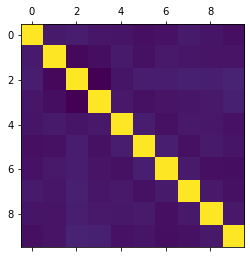

In [8]:
plt.matshow(df_dummy.corr(method="pearson"))
plt.show()

From this bivariate analysis, it seems that the variables not containing missings cannot explain if there is a missing in either of the three columns with missing values. Therefore the assumption of missing at random does not seem reasonable.

Therefore, we will assume that missing values are missing completely at random, _given the class_.

In the following, we will proceed by imputing the missing values taking into account an observation's class. In other words, we will impute a different value based on the value of the target.

Since there is considerable amount of missings, imputing with the median would flatten the regression curve, which can lead to a higher bias, so we discard the median. For the same reason, imputing with the average would considerably diminish the variance of the samples, which can lead to overfitting. In order not to provoke bias and overfitting in our models, we will impute a value derived from the kNN nearest neighbours of a sample, using the average weighted by the inverse of the distance. Since kNN works with distances, and we do not want to favor variables whose dynamic range is smaller than other variables, we need to scale the data beforehand. Let's use $k=5$, although this is quite arbitrary.

### Split data into training and testing sets

In [9]:
from sklearn.model_selection import train_test_split

seed = 2021
X_train, X_test, y_train, y_test = train_test_split(df_water[df_water.columns.difference(["Potability"])],
                                                    df_water["Potability"],
                                                    test_size=0.3, random_state=seed)

Let's visualize data using MDS to get a feel of its characteristics.

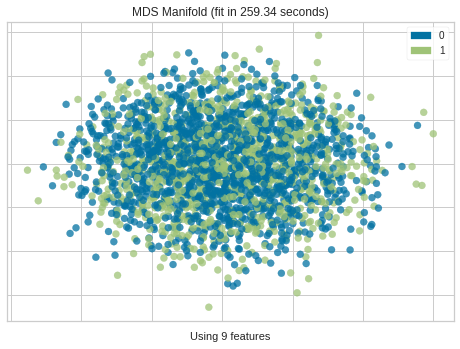

<AxesSubplot:title={'center':'MDS Manifold (fit in 259.34 seconds)'}, xlabel='Using 9 features'>

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer


# Reference: https://www.scikit-yb.org/en/latest/api/features/manifold.html
from yellowbrick.features import Manifold
from yellowbrick.datasets import load_occupancy

classes = [0, 1]

# MDS: multi-dimensional scaling uses similarity to plot points that are near to each other close in the embedding.
viz = Manifold(manifold="mds", classes=classes)

preproc = Pipeline(steps=[('scale', StandardScaler()),
                          ('impute', KNNImputer(n_neighbors=5, weights='distance'))])

X_train_preproc = preproc.fit_transform(X_train)

viz.fit_transform(X_train_preproc, y_train)
viz.show()

There are some outliers for both classes.

The classes are very much superposed, so this is going to be a difficult classification problem. 

## Hyperparameter Optimization and Model Comparison

Let's compare models on the training set. To make the comparison more solid, we will tune the models inside the CV procedure, by using a nested fine-tuning as described [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py).

We will also try reducing dimensionality prior to the classifier by using PCA.

After comparing the models, we will fine tune each one separately on the whole training set, and make them predict on the testing set.

In [14]:
def compare_models(models, pipeline, seed, p_grid, X_train, y_train, scoring, results, names):
    for name, model in models:
        pipeline.steps.append( (name, model) )
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

        clf = GridSearchCV(estimator=pipeline, param_grid=p_grid[name], cv=inner_cv)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cv_results = cross_validate(clf, X_train, y_train, cv=outer_cv, scoring=scoring)
        results[name] = {}

        for sc in scoring:
            results[name][f"{sc}"] = cv_results[f"test_{sc}"]
            msg = f"{name, sc, cv_results[f'test_{sc}'].mean(), cv_results[f'test_{sc}'].std()}"
            print(msg)
        print()
        names.append(name)
        pipeline.steps.pop()

In [15]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate 

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

import warnings


# prepare preprocessing
pipeline = Pipeline(steps=[('scale', StandardScaler()),
                           ('impute', KNNImputer(n_neighbors=5, weights='distance'))])

over = SMOTE(sampling_strategy=0.75)
pipelineSMOTE = Pipeline(steps=[('scale', StandardScaler()),
                                ('impute', KNNImputer(n_neighbors=5, weights='distance')),
                                ('over', over)])

pipelinePCA = Pipeline(steps=[('scale', StandardScaler()),
                              ('impute', KNNImputer(n_neighbors=5, weights='distance')),
                              ('PCA', PCA(n_components=0.9, svd_solver="full", random_state=seed))])


# prepare models
models = []
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('LR', LogisticRegression()))
models.append(('SVM', SVC()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('kNN', KNeighborsClassifier()))
models.append(('MLP', MLPClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB',  xgb.XGBClassifier()))


# Set up possible values of parameters to optimize over
p_grid = {"QDA": {"QDA__priors": [None, [0.5, 0.5]],
                  "QDA__reg_param": [0, 0.25, 0.5]
                 },
          "LR": {
                 "LR__class_weight": [None, "balanced"],
                },
          "SVM": {"SVM__C": [1, 10],
                  "SVM__kernel": ["linear", "poly", "rbf"],
                  "SVM__max_iter": [1500],
                  "SVM__gamma": ["scale", .01, 1,]
                 },
          "DT": {"DT__min_samples_split": [2, 5],
                 "DT__min_samples_leaf": [1, 2],
                 "DT__class_weight": [None]
                },
          "kNN": {"kNN__n_neighbors": [1, 5],
                  "kNN__weights": ["uniform", "distance"],
                  },
          "MLP": {"MLP__hidden_layer_sizes": [[9, 9]],
                  "MLP__activation": ["relu"],
                  "MLP__solver": ["adam"],
                  "MLP__batch_size": [128]
                  },
          "RF": {"RF__n_estimators": [300],
                 "RF__min_samples_split": [2, 5],
                 "RF__min_samples_leaf": [1, 2],
                 "RF__class_weight": [None]
                 },
          "XGB": {"XGB__max_depth": [2, 4],
                  "XGB__n_estimators": [200]
                 }
         }

results, resultsSMOTE, resultsPCA = {}, {}, {}
names, namesSMOTE, namesPCA = [], [], []
scoring = ("accuracy", "balanced_accuracy", "f1_weighted")  # the metrics by which to evaluate models

print("-"*15 + " Without SMOTE, Without PCA " + "-"*15)
compare_models(models, pipeline, seed, p_grid, X_train, y_train, scoring, results, names)

print("-"*15 + " With SMOTE " + "-"*15)
compare_models(models, pipelineSMOTE, seed, p_grid,
               X_train, y_train, scoring, resultsSMOTE, namesSMOTE)

print("-"*15 + " With PCA " + "-"*15)
compare_models(models, pipelinePCA, seed, p_grid,
               X_train, y_train, scoring, resultsPCA, namesPCA)



--------------- Without SMOTE, Without PCA ---------------
('QDA', 'accuracy', 0.6729181531904368, 0.01951243945174537)
('QDA', 'balanced_accuracy', 0.6094630361641238, 0.01879615957462467)
('QDA', 'f1_weighted', 0.6400921491870794, 0.019509273096336325)

('LR', 'accuracy', 0.6127351085994805, 0.0015283054403276094)
('LR', 'balanced_accuracy', 0.501123595505618, 0.0022471910112359605)
('LR', 'f1_weighted', 0.4665042177144084, 0.003668645913215985)

('SVM', 'accuracy', 0.6733567371635699, 0.02212927899727004)
('SVM', 'balanced_accuracy', 0.6020089767683634, 0.026499154577787055)
('SVM', 'f1_weighted', 0.6298933637357872, 0.02968128305786939)

('DT', 'accuracy', 0.5843974465089287, 0.026205549399986625)
('DT', 'balanced_accuracy', 0.5590962396394441, 0.02981721573282787)
('DT', 'f1_weighted', 0.5826778331670619, 0.027297906578956307)

('kNN', 'accuracy', 0.6201453701325266, 0.018540933727101333)
('kNN', 'balanced_accuracy', 0.5743459497438065, 0.023919536158062443)
('kNN', 'f1_weighted',

[22:20:33] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:20:33] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:20:33] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:20:34] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: 

[22:20:45] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:20:45] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:20:46] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:20:46] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: 

[22:28:39] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:28:40] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:28:40] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:28:41] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: 

[22:28:52] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:28:53] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:28:53] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:28:54] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: 

[22:35:30] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:35:31] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:35:31] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:35:32] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: 

[22:35:44] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:35:45] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:35:45] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:35:46] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: 

Distribution of F1-Weighted of the models


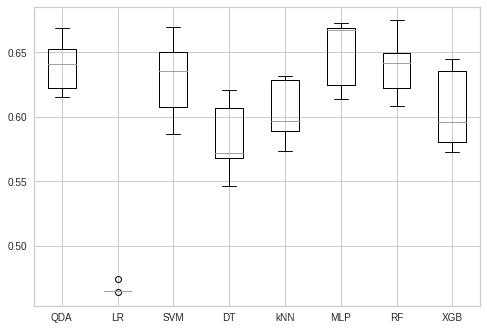

In [16]:
def boxplot_results(results, metric="f1_weighted"):
    acc, bal_acc, f1_w = {}, {}, {}
    for name in results:
        acc[name] = results[name]["accuracy"]
        bal_acc[name] = results[name]["balanced_accuracy"]
        f1_w[name] = results[name]["f1_weighted"]
    if metric=="accuracy":
        pd.DataFrame.from_dict(acc).boxplot()
    elif metric=="balanced_accuracy":
        pd.DataFrame.from_dict(bal_acc).boxplot()
    elif metric=="f1_weighted":
        pd.DataFrame.from_dict(f1_w).boxplot()

print("Distribution of F1-Weighted of the models")
boxplot_results(results)

Distribution of Recall of the models with SMOTE


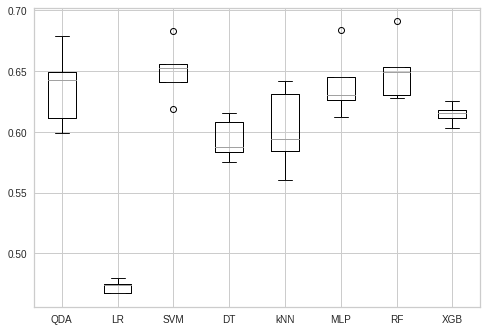

In [17]:
print("Distribution of Recall of the models with SMOTE")
boxplot_results(resultsSMOTE)

Distribution of Recall of the models with PCA


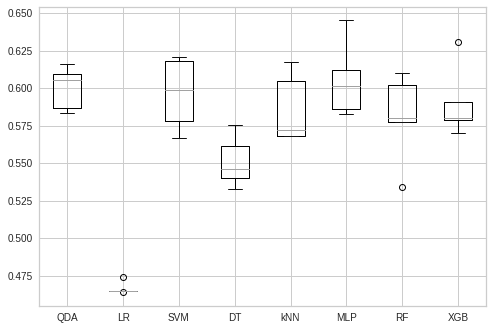

In [18]:
print("Distribution of Recall of the models with PCA")
boxplot_results(resultsPCA)

It seems that dimensionality reduction with PCA is not bringing any benefits in terms of F1-weighted, so let's skip it altogether. Upsampling with SMOTE, however, has slightly improved performance, so we shall keep it as part of our pipeline.
Let's take the most promising models, and fine-tune their paramaters on the whole training set and then have them predict on the testing set.
The chosen models are 4:

* QDA
* SVM
* MLP
* RF

In [56]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve

def grid_search_wrapper(name, clf, param_grid, X_train, y_train, X_test, y_test, scoring, n_splits=10, refit_score='f1_weighted'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
    grid_search = GridSearchCV(clf, param_grid[name], scoring=scoring, refit=refit_score,
                               cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)
    print('{}'.format(refit_score))
    print(grid_search.best_score_)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"specificity = {tn / (tn+fp)}")
    plot_confusion_matrix(grid_search, X_test, y_test)
    plt.show()  
    
    print(f" AUC: {roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])}")
    fig, ax = plt.subplots()
    plot_roc_curve(grid_search, X_test, y_test, ax=ax)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    plt.show() 
    
    
    print()
    print()
    return grid_search

Best params for f1_weighted
{'QDA__reg_param': 0}
f1_weighted
0.652060722633459
specificity = 0.8352941176470589


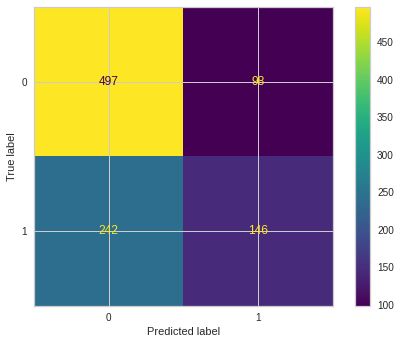

 AUC: 0.6586416009702851


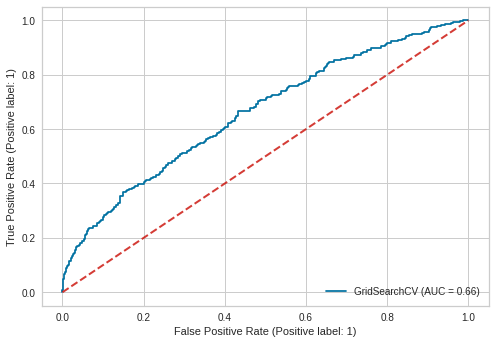

/home/alvaro/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Best params for f1_weighted
{'SVM_rbf__C': 1, 'SVM_rbf__gamma': 'scale', 'SVM_rbf__kernel': 'rbf', 'SVM_rbf__max_iter': 1500, 'SVM_rbf__probability': True}
f1_weighted
0.6510101598590803
specificity = 0.838655462184874


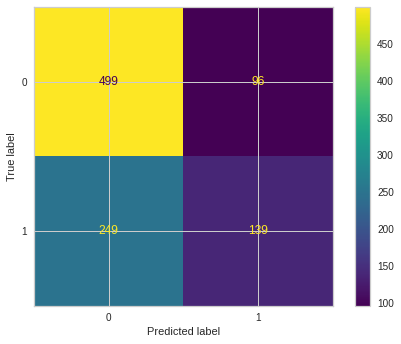

 AUC: 0.6547453001819284


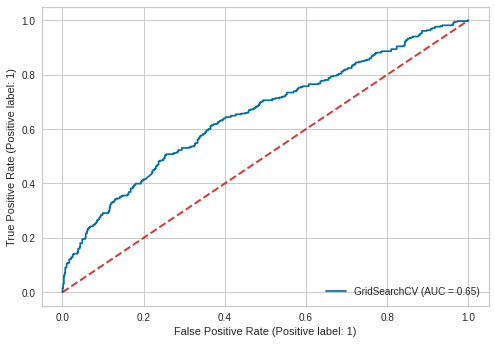

In [ ]:
from sklearn.metrics import confusion_matrix

pipelineFinal = Pipeline(steps=[('scale', StandardScaler()),
                                ('impute', KNNImputer(n_neighbors=5, weights='distance')),
                                ('over', over)])

p_grid_final = {"QDA": {
                        "QDA__reg_param": [0, 0.1, 0.2]
                       },
                "SVM_rbf": {"SVM_rbf__C": [.1, 1, 10],
                            "SVM_rbf__kernel": ["rbf"],
                            "SVM_rbf__max_iter": [1500],
                            "SVM_rbf__gamma": ["scale"],
                            "SVM_rbf__probability": [True]
                           },
                "RF":  {"RF__n_estimators": [250, 275, 300],
                        "RF__max_depth": [None, 100, 128, 156],
                        "RF__min_samples_split": [2, 4, 6],
                       },
                "MLP": {"MLP__hidden_layer_sizes": [[64, 32], [64]],
                        "MLP__activation": ["relu"],
                        "MLP__solver": ["adam"],
                        "MLP__batch_size": [128],
                        "MLP__max_iter": [500],
                       }
               }

modelsFinal = []
modelsFinal.append(('QDA', QuadraticDiscriminantAnalysis()))
modelsFinal.append(('SVM_rbf', SVC()))
modelsFinal.append(('RF', RandomForestClassifier()))
modelsFinal.append(('MLP', MLPClassifier()))

scoringFinal = ("accuracy", "balanced_accuracy", "f1_weighted")  # the metrics by which to evaluate models
for name, model in modelsFinal:
    pipelineFinal.steps.append( (name, model) )
    grid_search_wrapper(name, pipelineFinal, p_grid_final,
                        X_train, y_train, X_test, y_test,
                        scoringFinal, n_splits=5, refit_score='f1_weighted')              
    pipelineFinal.steps.pop()


Perhaps we can manage to drive up the f1 and/or the specificity by removing outliers as part of the preprocessing.

In [28]:
# Custom helper function that removes outliers from the passed dataset
# https://stackoverflow.com/questions/67956254/does-sklearn-pipeline-feed-both-x-and-y-to-the-following-steps
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.neighbors import LocalOutlierFactor


class WithoutOutliersClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, outlier_detector, classifier):
        self.outlier_detector = outlier_detector
        self.classifier = classifier

    def fit(self, X, y):
        self.outlier_detector_ = clone(self.outlier_detector)
        mask = self.outlier_detector_.fit_predict(X, y) == 1
        self.classifier_ = self.classifier.fit(X[mask], y[mask])
        return self

    def predict(self, X):
        return self.classifier_.predict(X)

So we will add this to the pipeline of the previous models:

Best params for f1_weighted
{'QDA__classifier__reg_param': 0, 'QDA__outlier_detector__nu': 0.1}
f1_weighted
0.6594229644637994
specificity = 0.8050420168067227


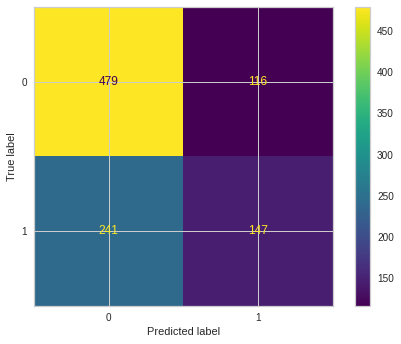

/home/alvaro/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Best params for f1_weighted
{'SVM__classifier__C': 1.5, 'SVM__classifier__gamma': 'scale', 'SVM__classifier__kernel': 'rbf', 'SVM__classifier__max_iter': 1000, 'SVM__outlier_detector__nu': 0.0125}
f1_weighted
0.6600840217805773
specificity = 0.8235294117647058


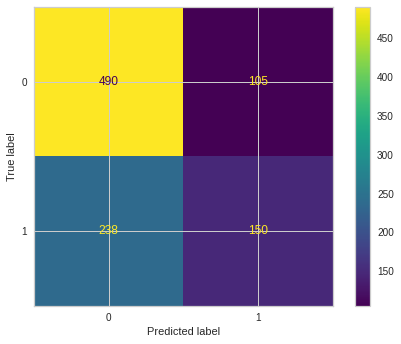



Best params for f1_weighted
{'RF__classifier__max_depth': 64, 'RF__classifier__min_samples_split': 8, 'RF__classifier__n_estimators': 250, 'RF__outlier_detector__nu': 0.0125}
f1_weighted
0.6569756224616208
specificity = 0.8050420168067227


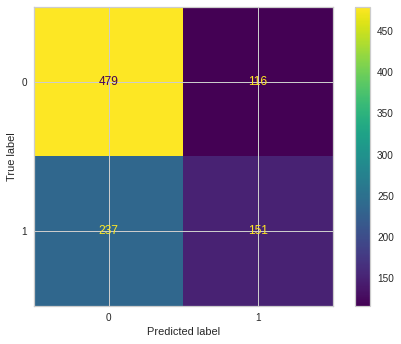

/home/alvaro/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best params for f1_weighted
{'MLP__classifier__activation': 'relu', 'MLP__classifier__batch_size': 128, 'MLP__classifier__hidden_layer_sizes': [64], 'MLP__classifier__max_iter': 500, 'MLP__classifier__solver': 'adam', 'MLP__outlier_detector__nu': 0.0125}
f1_weighted
0.6611526969505652
specificity = 0.7226890756302521


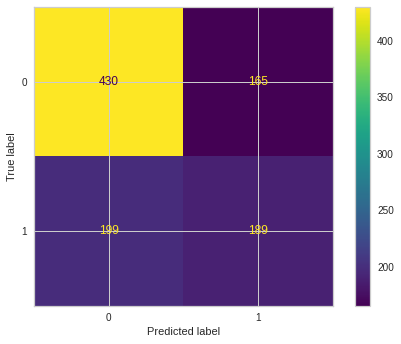

In [32]:
pipelineOutl = Pipeline(steps=[('scale', StandardScaler()),
                               ('impute', KNNImputer(n_neighbors=5, weights='distance')),
                               ('over', over)])

p_grid_outl = { "QDA": {"QDA__classifier__reg_param": [0, 0.1, 0.2],
                        "QDA__outlier_detector__nu": [0.5, 0.1, 0.15]
                       },
                "SVM": {"SVM__classifier__C": [.05, 1, 1.5],
                        "SVM__classifier__kernel": ["rbf"],
                        "SVM__classifier__max_iter": [1500],
                        "SVM__classifier__gamma": ["scale"],
                        "SVM__outlier_detector__nu": [0.0125, 0.025, 0.05]
                       },               
                "RF":  {"RF__classifier__n_estimators": [200, 225, 250],
                        "RF__classifier__max_depth": [64, 96, 128],
                        "RF__classifier__min_samples_split": [4, 8],
                        "RF__outlier_detector__nu": [0.0125, 0.025, 0.05]
                       },
                       "MLP": {"MLP__classifier__hidden_layer_sizes": [[32], [64]],
                        "MLP__classifier__activation": ["relu"],
                        "MLP__classifier__solver": ["adam"],
                        "MLP__classifier__batch_size": [128],
                        "MLP__classifier__max_iter": [500],
                        "MLP__outlier_detector__nu": [0.0125, 0.025, 0.05]
                       }
               }

modelsOutl = []
modelsOutl.append(('QDA', QuadraticDiscriminantAnalysis()))
modelsOutl.append(('SVM', SVC()))
modelsOutl.append(('RF', RandomForestClassifier()))
modelsOutl.append(('MLP', MLPClassifier()))

from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest


scoringOutl = ("accuracy", "balanced_accuracy", "f1_weighted")  # the metrics by which to evaluate models
for name, model in modelsOutl:
    mod = WithoutOutliersClassifier(OneClassSVM(kernel="rbf"), model)
    pipelineOutl.steps.append( (name, mod) )

    grid_search_wrapper(name, pipelineOutl, p_grid_outl,
                        X_train, y_train, X_test, y_test,
                        scoringOutl, n_splits=10, refit_score='f1_weighted')              
    pipelineOutl.steps.pop()